In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from __future__ import print_function
from builtins import range
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

# Dataset

In [2]:
def load_sqfm_csv(fname):
    df = pd.read_csv(fname)
    Fmatrix = df[['F' + str(i) for i in range(1, 9)]].as_matrix().astype(float)
    ssq = df['SQ'].as_matrix()
    
    # SQ: str => one-hot
    sqwidth = len(ssq[0])
    sq = np.zeros(shape=(len(ssq), 4 * sqwidth), dtype=float)
    sqchars = np.stack([np.fromstring(s, dtype=np.uint8) for s in ssq])
    for i, c in enumerate(('A', 'U', 'G', 'C')):
        sq[:,i::4] = (sqchars == ord(c))
    return sq, Fmatrix

def drop_bad_entries(sq, Fmatrix):
    Fcnt = (Fmatrix > 0).sum(axis=1)
    selection = np.logical_and(Fcnt <= threshold, Fcnt > 0)
    print('total: {}\tcnt > {}: {}\tempty:{}'.format(len(Fcnt), threshold, (Fcnt > threshold).sum(), (Fcnt == 0).sum())) 
    sq, Fmatrix = sq[selection], Fmatrix[selection]
    return sq, Fmatrix

#def Fmx2cls_NormedMean(Fmatrix):
#    Fnormalized = Fmatrix / np.atleast_2d(Fmatrix.sum(axis=1)).T
#    return (np.dot(Fnormalized, np.arange(1, 9).reshape(8, 1))[:,0] - 1.0) / 7.0

def Fmx2cls_Highest(Fmatrix, min_maxcls_ratio=0.2, min_maxcls_value=1):
    Ftotal = np.atleast_2d(Fmatrix.sum(axis=1)).T
    good_F = np.logical_and(Fmatrix[:,::-1] >= min_maxcls_value, Fmatrix[:,::-1] / Ftotal >= min_maxcls_ratio)
    assert (np.logical_not(good_F).sum(axis=1) == 0).sum() == 0
    return np.argmax(good_F, axis=1)

sq20, fm20 = load_sqfm_csv('./raw_data/sq20.csv')
sq30, fm30 = load_sqfm_csv('./raw_data/sq30.csv')
sqmore, fmmore = load_sqfm_csv('./raw_data/sq_any.csv')

#fnm20 = Fmx2cls_NormedMean(fm20)
#fnm30 = Fmx2cls_NormedMean(fm30)
#fnmmore = Fmx2cls_NormedMean(fmmore)

fh20 = Fmx2cls_Highest(fm20)
fh30 = Fmx2cls_Highest(fm30)
fhmore = Fmx2cls_Highest(fmmore)

def preproc20(sq20, f20, F1_reptimes = 10):
    repeat = lambda a, sel, times: np.concatenate((a, np.repeat(a[sel], times - 1, 0))) 
    return repeat(sq20, f20 < 0.5, F1_reptimes), repeat(f20, f20 < 0.5, F1_reptimes)

sq20.shape: (11692, 92)	 fh20.shape: (11692,)	 fh20.range: [0, 7]


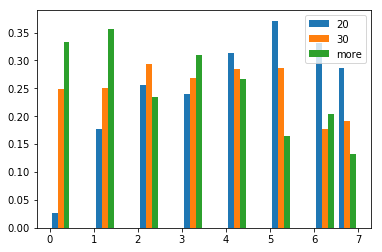

In [3]:
print('sq20.shape: {}\t fh20.shape: {}\t fh20.range: [{}, {}]'.format(sq20.shape, fh20.shape, fh20.min(), fh20.max()))
plt.hist([fh20, fh30, fhmore], 14, label=['20', '30', 'more'], normed=True)
plt.legend();

In [24]:
# TODO: change quadclust classification for f30

def fcls_accuracy(model, sq, f, fclassify, kF1 = 1, normalize_classes=True, bootstrap=1024, test_size=None, report=True):
    fcls, fcls_labels = fclassify(f)
    classes = np.unique(fcls)
    fcls_sizes = np.array([(fcls == c).sum() for c in classes])
    size = min(kF1 * fcls_sizes[0], fcls_sizes[1:].min())
    
    accuracy = np.zeros(bootstrap, dtype=float)
    for bi in range(bootstrap):
        if report and (bi & 0xF) == 0xF:
            print('\rbootstrap: {}/{}'.format(bi + 1, bootstrap), end='')
        
        # train_test_split
        if normalize_classes:
            X_train, X_test, y_train, y_test = list(), list(), list(), list()  
            for i, c in enumerate(classes):
                choice = np.random.choice(np.arange(fcls_sizes[i]), min(size, fcls_sizes[i]), replace=False)
                cls_split = train_test_split(sq[fcls == c][choice], fcls[fcls == c][choice], test_size=test_size)
                X_train.append(cls_split[0])
                X_test.append(cls_split[1])
                y_train.append(cls_split[2])
                y_test.append(cls_split[3])
            
            X_train[0] = np.repeat(X_train[0], kF1, axis=0)
            y_train[0] = np.repeat(y_train[0], kF1, axis=0)
            X_test[0] = np.repeat(X_test[0], kF1, axis=0)
            y_test[0] = np.repeat(y_test[0], kF1, axis=0)
            
            X_train = np.concatenate(X_train)
            X_test = np.concatenate(X_test)
            y_train = np.concatenate(y_train)
            y_test = np.concatenate(y_test)
        else:
            assert kF1 == 1
            X_train, X_test, y_train, y_test = train_test_split(sq, f, test_size=test_size)
        
        # fit & test prediction
        L = model.fit(X_train, y_train, X_test, y_test)
        y_test_pred = L.predict(X_test)
        accuracy[bi] = accuracy_score(y_test, y_test_pred)
    if report:
        print('\rbootstrap: {}'.format(bootstrap) + ' ' * 10)
        print('cls {} sizes: {}, chosen {}'.format(fcls_labels, fcls_sizes, size))
    return accuracy.mean(), np.median(accuracy), np.percentile(accuracy, 5), np.percentile(accuracy, 95)

def fval2cls(f):
    fcls = np.zeros_like(f)
    for cls in range(8):
        fcls[np.logical_and(f >= (cls - 0.5), f < (cls + 0.5))] = cls
    fcls[f >= (7 + 0.5)] = 7
    return fcls, ['F' + str(i) for i in range(1, 9)]

def fcls_accuracy_F1F8(model, sq, f, bootstrap, kF1 = 1, normalize=True):
    acc_desc = fcls_accuracy(model, sq, f, fval2cls, kF1, normalize, bootstrap)
    print('accuracy (mean, median, min, max): {:.3f} {:.3f} {:.3f} {:.3f}'.format(*acc_desc), end='\n\n')

def fcls_accuracy_F1F2merged(model, sq, f, bootstrap):
    acc_desc = fcls_accuracy(model, sq, f, fval2_F1F2merged,bootstrap=bootstrap)
    print('accuracy (mean, median, min, max): {:.3f} {:.3f} {:.3f} {:.3f}'.format(*acc_desc), end='\n\n')
    
def fcls_accuracy_all(model, sq, f, bootstrap=1024, normalize=True):
    def fval2biclust(f):
        return f >= (4.2 - 1), ['F1~F3', 'F4~F8'] 
    
    def fval2triclust(f):
        fcls = np.zeros(f.shape, dtype=np.int)
        fcls += (f >= (4.2 - 1))
        fcls += (f >= (5.5 - 1))
        return fcls, ['F1~F3', 'F4~F5', 'F6~F8']


    def fval2quadclust(f):
        fcls = np.zeros(f.shape, dtype=np.int)
        fcls += (f >= (4.2 - 1))
        fcls += (f >= (5.5 - 1))
        fcls += (f >= (5.99 - 1))
        return fcls, ['F1~F3', 'F4~F5', 'F6~F7', 'F7~F8']
    for fclassify in (fval2cls, fval2biclust, fval2triclust, fval2quadclust):
        acc_desc = fcls_accuracy(model, sq, f, fclassify,bootstrap=bootstrap, normalize_classes=normalize)
        print('accuracy (mean, median, min, max): {:.3f} {:.3f} {:.3f} {:.3f}'.format(*acc_desc), end='\n\n')

In [25]:
def fcls_binsplit(threshold):
    def func(f):
        fcls = (f >= (threshold - 1.5)).astype(f.dtype)
        labels = [':F{}'.format(threshold-1), 'F{}:'.format(threshold)]
        return fcls, labels
    return func
   
def fbin_accuracy(model, sq, f, bootstrap = 256):
    means, medians, mins, maxs = list(), list(), list(), list()
    ts = np.arange(2, 9)
    for i in ts:
        acc_desc = fcls_accuracy(model, sq, f, fcls_binsplit(i), bootstrap=bootstrap)
        means.append(acc_desc[0])
        medians.append(acc_desc[1])
        mins.append(acc_desc[2])
        maxs.append(acc_desc[3])
        print('accuracy (mean, median, min, max): {:.3f} {:.3f} {:.3f} {:.3f}'.format(*acc_desc), end='\n\n')
    plt.title('A(k) = accuracy [:Fk-1, Fk:]')
    plt.plot(ts, means, label='mean')
    plt.plot(ts, medians, label='median')
    plt.plot(ts, mins, label='min')
    plt.plot(ts, maxs, label='max')
    plt.legend()
    plt.show()
    

## LogisticRegression

In [6]:
class lrModel(object):
    def __init__(self):
        self.inst = LogisticRegression()
    
    def fit(self, X_train, y_train, X_test, y_test):
        return self.inst.fit(X_train, y_train)
        
    def predict(self, X):
        return self.inst.predict_proba(X)

In [7]:
fcls_accuracy_F1F8(lrModel(), sq20, fh20, 256)
fcls_accuracy_F1F8(lrModel(), sq20, fh20, 256, normalize=False)
fcls_accuracy_F1F8(lrModel(), sq20, fh20, 256, 8)

bootstrap: 256          
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.278 0.279 0.243 0.314

bootstrap: 256          
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.333 0.333 0.320 0.348

bootstrap: 256          
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.327 0.327 0.306 0.348



In [8]:
fcls_accuracy_F1F8(lrModel(), sq30, fh30, 256)
fcls_accuracy_F1F8(lrModel(), sq30, fh30, 256, normalize=False)

bootstrap: 256          
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [1483 1492 1743 1598 1689 1700 1050 1134], chosen 1050
accuracy (mean, median, min, max): 0.280 0.280 0.267 0.294

bootstrap: 256          
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [1483 1492 1743 1598 1689 1700 1050 1134], chosen 1050
accuracy (mean, median, min, max): 0.279 0.279 0.267 0.292



bootstrap: 256          
cls [':F1', 'F2:'] sizes: [  154 11538], chosen 154
accuracy (mean, median, min, max): 0.773 0.782 0.679 0.846

bootstrap: 256          
cls [':F2', 'F3:'] sizes: [ 1187 10505], chosen 1187
accuracy (mean, median, min, max): 0.787 0.787 0.761 0.815

bootstrap: 256          
cls [':F3', 'F4:'] sizes: [2684 9008], chosen 2684
accuracy (mean, median, min, max): 0.800 0.799 0.784 0.816

bootstrap: 256          
cls [':F4', 'F5:'] sizes: [4085 7607], chosen 4085
accuracy (mean, median, min, max): 0.806 0.807 0.792 0.820

bootstrap: 256          
cls [':F5', 'F6:'] sizes: [5912 5780], chosen 5780
accuracy (mean, median, min, max): 0.809 0.809 0.799 0.820

bootstrap: 256          
cls [':F6', 'F7:'] sizes: [8082 3610], chosen 3610
accuracy (mean, median, min, max): 0.802 0.802 0.788 0.817

bootstrap: 256          
cls [':F7', 'F8:'] sizes: [10021  1671], chosen 1671
accuracy (mean, median, min, max): 0.799 0.798 0.778 0.821



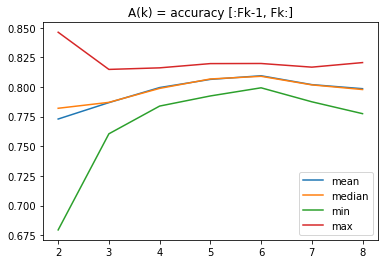

In [9]:
fbin_accuracy(lrModel(), sq20, fh20, 256)

bootstrap: 256          
cls [':F1', 'F2:'] sizes: [ 1483 10406], chosen 1483
accuracy (mean, median, min, max): 0.760 0.759 0.740 0.783

bootstrap: 256          
cls [':F2', 'F3:'] sizes: [2975 8914], chosen 2975
accuracy (mean, median, min, max): 0.783 0.783 0.767 0.799

bootstrap: 256          
cls [':F3', 'F4:'] sizes: [4718 7171], chosen 4718
accuracy (mean, median, min, max): 0.799 0.799 0.787 0.810

bootstrap: 256          
cls [':F4', 'F5:'] sizes: [6316 5573], chosen 5573
accuracy (mean, median, min, max): 0.797 0.798 0.786 0.808

bootstrap: 256          
cls [':F5', 'F6:'] sizes: [8005 3884], chosen 3884
accuracy (mean, median, min, max): 0.789 0.789 0.775 0.801

bootstrap: 256          
cls [':F6', 'F7:'] sizes: [9705 2184], chosen 2184
accuracy (mean, median, min, max): 0.795 0.796 0.777 0.815

bootstrap: 256          
cls [':F7', 'F8:'] sizes: [10755  1134], chosen 1134
accuracy (mean, median, min, max): 0.797 0.798 0.769 0.824



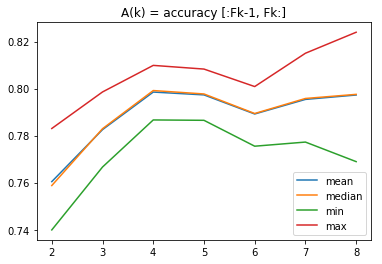

In [10]:
fbin_accuracy(lrModel(), sq30, fh30, 256)

## NN

In [163]:
def nnopt_epoch(network, epoch, batch_size, optimizer, loss_fn, X_train, y_train, report):
    network.train()
    
    np_X_train, np_y_train = X_train.numpy(), y_train.numpy()
    np_X_train_src, np_y_train_src = np_X_train.copy(), np_y_train.copy()
    # shuffle array
    shuffle = np.random.permutation(X_train.size(0))
    np.copyto(np_X_train, np_X_train_src[shuffle])
    np.copyto(np_y_train, np_y_train_src[shuffle]) 
        
    for off in range(0, X_train.size(0), batch_size):
        if report and off % (128 * batch_size) == 0:
            msg = '\r[epoch: {}] fed to network {}/{}'.format(epoch, off, y_train.size(0)) 
            print(msg, end=' ' * 20)
        optimizer.zero_grad()            
        
        X = Variable(X_train[off:off + batch_size])
        y = Variable(y_train[off:off + batch_size], requires_grad=False)
        
        # forward pass
        output = network.forward(X)

        # back-prop
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        del X, y, output, loss
        
def nnopt_test(network, X, y, loss_fn):
    network.eval()
    output = network.forward(X)
    err = loss_fn(output, y).data[0]
    out = output.data.numpy().copy()
    return err, out


def nnoptimize(network, X_train, y_train, X_test, y_test, batch_size=10, max_epoch=256,\
               loss_fn = torch.nn.CrossEntropyLoss(),lr=0.01, wd=0.1,\
               unravel=False, report=True, plot=True):
    pt = lambda t,pyt=None: torch.from_numpy(t).type(pyt) if pyt is not None else torch.from_numpy(t)
    preproc_X = lambda t: t.view(t.size(0), -1) if unravel else t
    
    optimizer = torch.optim.Adam(network.parameters(), lr=lr, weight_decay=wd)
    
    best_err, best_epoch, best_state = float('inf'), None, None
    errors = []

    X_test = Variable(preproc_X(pt(X_test, torch.FloatTensor)), requires_grad=False) 
    y_test = Variable(pt(y_test), requires_grad=False)
    tX_train = preproc_X(pt(X_train, torch.FloatTensor))
    ty_train = pt(y_train)
    
    for epoch in range(max_epoch):       
        # optimize epoch
        nnopt_epoch(network, epoch, batch_size, optimizer, loss_fn, tX_train, ty_train, report)
        
        # test loss
        err, out = nnopt_test(network, X_test, y_test, loss_fn)
        errors.append(err)
        if best_err > err:
            best_err = err
            best_epoch = epoch
            best_state = network.state_dict()
        elif epoch > 0:
            network.load_state_dict(best_state)
            lr = lr * 0.1
            errors.pop()
            if lr * (tX_train.size(0) + X_test.size(0)) < 0.0001:
                break
            
        del err, out
    network.load_state_dict(best_state)
    if plot:
        plt.title('nnoptimize: {} for {} epochs'.format(loss_fn.__class__.__name__, max_epoch))
        plt.plot(errors)
        plt.show()
    return network, errors, best_epoch


class nnModel(object):
    def __init__(self, nn_inst, loss_fn = None, batch_size=10):
        self.inst = nn_inst
        self.loss_fn = loss_fn if loss_fn is not None else nn.CrossEntropyLoss()
        self.batch_size = batch_size
        
    def fit(self, X_train, y_train, X_test, y_test):
        network, errors, best_epoch = nnoptimize(self.inst, X_train, y_train, X_test, y_test,\
                                                 loss_fn=self.loss_fn, batch_size=self.batch_size, plot=False)
        # TODO: may be add some info
        return self
    
    def predict(self, X):
        X = torch.from_numpy(X)
        y = self.inst(Variable(X.type(torch.FloatTensor), requires_grad=False))
        y = y.data.numpy()
        return y.argmax(axis=1)

In [12]:
d20 = (sq20.shape[1], int(sq20.shape[1] / 2), int(sq20.shape[1] / 4))
d30 = (sq30.shape[1], int(sq30.shape[1] / 2), int(sq30.shape[1] / 4))
print(fcls_accuracy(nnModel(nn.Linear(d20[0], 8)), sq20, fh20, fcls_binsplit(5), bootstrap=20))

bootstrap: 20          rk 5120/6126                                        
cls [':F4', 'F5:'] sizes: [4085 7607], chosen 4085
(0.74863013698630154, 0.75318003913894327, 0.71504403131115468, 0.78444227005870837)


#### Binary classification

In [ ]:
fbin_accuracy(nnModel(nn.Linear(d20[0], 2)), sq20, fh20, 32)

In [ ]:
fbin_accuracy(nnModel(nn.Linear(sq30.shape[1], 2)), sq30, fh30, 32)

In [ ]:
model = nn.Sequential(nn.Linear(d20[0], d20[1]), nn.Sigmoid(), nn.Linear(d20[1], 2)) 
fbin_accuracy(nnModel(model), sq20, fh20, 8)

In [ ]:
model = nn.Sequential(nn.Linear(d30[0], d30[1]), nn.Sigmoid(), nn.Linear(d30[1], 2)) 
fbin_accuracy(nnModel(model), sq30, fh30, 8)

In [ ]:
model = nn.Sequential(nn.Linear(d20[0], d20[1]), nn.ReLU(), nn.Linear(d20[1], 2)) 
fbin_accuracy(nnModel(model), sq20, fh20, 32)

In [ ]:
model = nn.Sequential(nn.Linear(d30[0], d30[1]), nn.ReLU(), nn.Linear(d30[1], 2)) 
fbin_accuracy(nnModel(model), sq30, fh30, 32)

#### F-Clasification

In [15]:
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8)), sq20, fh20, 32)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8)), sq20, fh20, 32, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8)), sq20, fh20, 32, normalize=False)

bootstrap: 32          rk 0/920                                                            
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.237 0.245 0.183 0.286

bootstrap: 32          rk 5120/6338                                                                                
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.248 0.250 0.213 0.282

bootstrap: 32          ork 7680/8769                                                                                                                                                               
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.242 0.242 0.199 0.277



In [171]:
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 50), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 100), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 250), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 500), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 1000), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 2000), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 4000), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 100000), sq20, fh20, 256, 8)

bootstrap: 256          k 0/6338                                                                                                                                                                                                                                                                    
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.272 0.274 0.241 0.301

bootstrap: 256          k 0/6338                                                                                 
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.280 0.282 0.256 0.304

bootstrap: 256          k 0/6338                                                                                                                                                                                                                   

In [172]:
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 500), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 750), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 1000), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 1250), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 1500), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 1750), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 2000), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 2250), sq20, fh20, 256, 8)
fcls_accuracy_F1F8(nnModel(nn.Linear(sq20.shape[1], 8), batch_size = 2500), sq20, fh20, 256, 8)

bootstrap: 256          rk 0/6338                                                                                                                                                                                    
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.289 0.290 0.269 0.310

bootstrap: 256          k 0/6338                                                                                                                                                                                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.291 0.291 0.273 0.309

bootstrap: 256          k 0/6338                                                                                                                                             
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', '

In [ ]:
model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.Sigmoid(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 8)

In [26]:
model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.ReLU(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.ReLU(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.ReLU(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, normalize=False)

bootstrap: 32          rk 0/920                                        
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.245 0.237 0.208 0.280

bootstrap: 32          rk 5120/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.258 0.261 0.230 0.282

bootstrap: 32          ork 7680/8769                                                            
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.238 0.243 0.178 0.276



In [175]:
model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.ReLU(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 256, 8)

model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.ReLU(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=2000), sq20, fh20, 256, 8)

model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.ReLU(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=4000), sq20, fh20, 256, 8)

model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.ReLU(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=6000), sq20, fh20, 256, 8)

model = nn.Sequential(nn.Linear(d20[0], d20[0] // 4), nn.ReLU(), nn.Linear(d20[0] // 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=8000), sq20, fh20, 256, 8)

bootstrap: 256          k 0/6338                                                                                                                                                                                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.262 0.261 0.252 0.274

bootstrap: 256          rk 0/6338                                                                                                                                                                                                                            
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.264 0.264 0.254 0.275

bootstrap: 256          k 0/6338                                                                                                                                                      

CNN

In [27]:
class nnConvModule(nn.Module):
    def __init__(self, kernel_size, in_channels = 1, out_channels = 1, bias=True):
        super(nnConvModule, self).__init__()
        stride = 4
        self.nn_conv = nn.Conv1d(in_channels, out_channels, kernel_size * stride, stride, bias=bias)
        self.in_channels = in_channels
        self.out_channels = out_channels
    
    def forward(self, x):
        y = self.nn_conv(x.view(x.size(0), 1, x.size(1)))
        return y.view(y.size(0), y.size(1) * y.size(2))
        

In [199]:
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4)),
                      nn.Linear(4 * (d20[0]//4) - 6, 20), nn.Tanh(), nn.Linear(20, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 32, 8)

bootstrap: 32          rk 0/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.147 0.147 0.147 0.147



In [206]:
model = nn.Sequential(nn.Linear(d20[0], 20), nn.Tanh(), nnCat(
                    nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 2), nnFromConvs()),
                    nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 3), nnFromConvs()),
                    nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4), nnFromConvs()),
                    nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 5), nnFromConvs())),
                nn.Linear(4 * 20 - 10, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 32, 8)

bootstrap: 32          ork 0/6338                    
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.315 0.316 0.301 0.326



In [196]:
model = nn.Sequential(nnConvModule(1), nn.Tanh(), nn.Linear(d20[0]//4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 32, 8)

bootstrap: 32          rk 0/6338                                                             
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.252 0.253 0.244 0.261



In [29]:
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32,  normalize=False)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.246 0.244 0.217 0.280

bootstrap: 32          rk 5120/6338                                                                                                                                                                                                                                                                                                                                                                                            
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.265 0.263 0.247 0.287

bootstrap: 32          rk 7680/8769                                                                                                                                                   

In [178]:
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 256, 8)
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=2000), sq20, fh20, 256, 8)
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=3000), sq20, fh20, 256, 8)
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=4000), sq20, fh20, 2, 8)
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=5000), sq20, fh20, 256, 8)
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=6000), sq20, fh20, 256, 8)
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=7000), sq20, fh20, 256, 8)
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=8000), sq20, fh20, 256, 8)
model = nn.Sequential(nnConvModule(2), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=100000), sq20, fh20, 256, 8)

bootstrap: 256          rk 0/6338                                                                                                                                                                
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.271 0.271 0.256 0.284

bootstrap: 256          k 0/6338                                                                                                                                                                                                                                                                                                                                                                                                                 
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.271 0.271 0.258 0.285

bootstrap: 256        

In [30]:
model = nn.Sequential(nnConvModule(2), nn.ReLU(), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnConvModule(2), nn.ReLU(), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

model = nn.Sequential(nnConvModule(2), nn.ReLU(), nn.Linear(d20[0]//4 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, normalize=False)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.206 0.210 0.157 0.251

bootstrap: 32          rk 5120/6338                                                                                                                                                                                                                                                                                                                                                                        
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.221 0.223 0.179 0.255

bootstrap: 32          ork 7680/8769                                                                                                                                                                      

In [35]:
model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, normalize=False)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.255 0.255 0.224 0.282

bootstrap: 32          ork 5120/6338                                                                                                                                                                                                                           
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.261 0.262 0.232 0.287

bootstrap: 32          ork 7680/8769                                                                                                                                                                                                                                                                                                                  

In [179]:
model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=2000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=3000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=4000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=5000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=6000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=7000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=8000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(3), nn.Linear(d20[0]//4 - 2, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=100000), sq20, fh20, 256, 8)


bootstrap: 256          k 0/6338                                                                                                                                                                                                                                                                                                                                 
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.274 0.274 0.261 0.287

bootstrap: 256          k 0/6338                                                                                                                                                                                                                                                                                                                                                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1

In [36]:
model = nn.Sequential(nnConvModule(4), nn.Linear(d20[0]//4 - 3, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnConvModule(4), nn.Linear(d20[0]//4 - 3, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

model = nn.Sequential(nnConvModule(4), nn.Linear(d20[0]//4 - 3, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, normalize=False)

bootstrap: 32          rk 0/920                                         
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.257 0.256 0.223 0.285

bootstrap: 32          rk 5120/6338                                                                                                                                                                                                                                                                                                            
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.265 0.265 0.241 0.290

bootstrap: 32          rk 7680/8769                                                                                                                                                                                                               

In [180]:
model = nn.Sequential(nnConvModule(4), nn.Linear(d20[0]//4 - 3, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(4), nn.Linear(d20[0]//4 - 3, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=2000), sq20, fh20, 256, 8)

model = nn.Sequential(nnConvModule(4), nn.Linear(d20[0]//4 - 3, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=4000), sq20, fh20, 256, 8)

bootstrap: 256          rk 0/6338                                                                                                                                                                                                                            
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.275 0.275 0.263 0.288

bootstrap: 256          k 0/6338                                                                                                                         
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.274 0.275 0.262 0.286

bootstrap: 256          rk 0/6338                                                                                                                                                                                                        
cls ['F1

In [38]:
model = nn.Sequential(nnConvModule(5), nn.Linear(d20[0]//4 - 4, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnConvModule(5), nn.Linear(d20[0]//4 - 4, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

model = nn.Sequential(nnConvModule(5), nn.Linear(d20[0]//4 - 4, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, normalize=False)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.255 0.258 0.225 0.285

bootstrap: 32          rk 5120/6338                                                                                                                                                                                                                                                                                        
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.267 0.264 0.235 0.296

bootstrap: 32          rk 7680/8769                                                                                                                                                                                                                                                       

In [181]:
model = nn.Sequential(nnConvModule(5), nn.Linear(d20[0]//4 - 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 32, 8)

model = nn.Sequential(nnConvModule(5), nn.Linear(d20[0]//4 - 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=2000), sq20, fh20, 32, 8)

model = nn.Sequential(nnConvModule(5), nn.Linear(d20[0]//4 - 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=4000), sq20, fh20, 32, 8)

model = nn.Sequential(nnConvModule(5), nn.Linear(d20[0]//4 - 4, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=100000), sq20, fh20, 32, 8)

bootstrap: 32          rk 0/6338                                         
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.275 0.276 0.262 0.291

bootstrap: 32          rk 0/6338                                         
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.272 0.273 0.258 0.285

bootstrap: 32          rk 0/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.274 0.274 0.263 0.285

bootstrap: 32          rk 0/6338                                                             
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.275 0.276 0.260 0.283



In [148]:
class nnBypass(object):
    def __init__(self):
        super(nnBypass).__init__()
    
    def forward(self, x):
        return x
    

class nnFitLogRegr(object):
    def fit(self, X_train, y_train):
        self.lr_model = LogisticRegression().fit(X_train, y_train)
        return self
    
    def forward(self, x): # breaks calculations graph: use it only on input data
        arr = self.lr_model.predict_proba(x.data.numpy())
        y = Variable(torch.from_numpy(arr)).float()
        return y
    
class nnCat(nn.Module):
    def __init__(self, *modules, **kwargs):
        assert len(kwargs) <= 2
        super(nnCat, self).__init__()
        self.cat_modules = list(modules)
        for i,m in enumerate(modules):
            self.add_module('catmodule' + str(i), m)
        if ('bypass' in kwargs and kwargs['bypass']):
            self.cat_modules.append(nnBypass())
        if ('fitlr' in kwargs and kwargs['fitlr']):
            self.lr = nnFitLogRegr()
            self.cat_modules.append(self.lr)

    def forward(self, x):
        return torch.cat([m.forward(x) for m in self.cat_modules], 1)

In [84]:
cd20 = d20[0] // 4
model = nn.Sequential(nnCat(nnConvModule(2), bypass=True), nn.Linear(d20[0] + cd20 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnCat(nnConvModule(2), bypass=True), nn.Linear(d20[0] + cd20 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)


model = nn.Sequential(nnCat(nnConvModule(2), bypass=True), nn.Linear(d20[0] + cd20 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, normalize=False)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.252 0.250 0.218 0.290

bootstrap: 32          ork 5120/6338                                       
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.252 0.256 0.205 0.286

bootstrap: 32          rk 7680/8769                                                                                                                                                                                                                                                                                                                                 
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.256 0.259 0.22

In [42]:
cd20 = d20[0] // 4
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2)), nn.Linear(2 * cd20 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2)), nn.Linear(2 * cd20 - 1, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.258 0.258 0.231 0.283

bootstrap: 32          rk 5120/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.261 0.261 0.233 0.284



In [43]:
cd20 = d20[0] // 4
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), bypass=True), nn.Linear(d20[0] + 3 * cd20 - 3, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), bypass=True), nn.Linear(d20[0] + 3 * cd20 - 3, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.258 0.256 0.229 0.301

bootstrap: 32          rk 5120/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.263 0.268 0.227 0.295



In [47]:
cd20 = d20[0] // 4
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.260 0.255 0.221 0.318

bootstrap: 32          ork 5120/6338                    
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.276 0.278 0.229 0.303



### Best?

In [185]:
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=2000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=3000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=4000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=5000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=6000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=7000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=8000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), bypass=True), nn.Linear(d20[0] + 4 * cd20 - 6, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=100000), sq20, fh20, 128, 8)

bootstrap: 128          rk 0/6338                    
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.307 0.308 0.291 0.321

bootstrap: 128          rk 0/6338                                                                                
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.307 0.309 0.289 0.322

bootstrap: 128          k 0/6338                                                                                                                         
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.306 0.305 0.287 0.329

bootstrap: 128          k 0/6338                                                                                                                         

In [48]:
cd20 = d20[0] // 4
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), nnConvModule(5),\
                            bypass=True), nn.Linear(d20[0] + 5 * cd20 - 10, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), nnConvModule(5),\
                            bypass=True), nn.Linear(d20[0] + 5 * cd20 - 10, 8))
fcls_accuracy_F1F8(nnModel(model), sq20, fh20, 32, 8)

bootstrap: 32          rk 0/920                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 154
accuracy (mean, median, min, max): 0.253 0.253 0.220 0.292

bootstrap: 32          rk 5120/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.268 0.274 0.221 0.293



In [186]:
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), nnConvModule(5),\
                            bypass=True), nn.Linear(d20[0] + 5 * cd20 - 10, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=100000), sq20, fh20, 128, 8)

bootstrap: 128          k 0/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.306 0.306 0.291 0.326



In [187]:
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), nnConvModule(5),\
                            nn.Embeddingbypass=True), nn.Linear(d20[0] + 5 * cd20 - 10, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 128, 8)

model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), nnConvModule(5),\
                            bypass=True), nn.Linear(d20[0] + 5 * cd20 - 10, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=2000), sq20, fh20, 128, 8)

bootstrap: 128          rk 0/6338                    
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.307 0.307 0.291 0.326

bootstrap: 128          k 0/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.307 0.308 0.289 0.326



In [188]:
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), nnConvModule(5),\
                            bypass=True), nn.Linear(d20[0] + 5 * cd20 - 10, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 128, 8)
model = nn.Sequential(nnCat(nnConvModule(1), nnConvModule(2), nnConvModule(3), nnConvModule(4), nnConvModule(5),\
                            bypass=True), nn.Linear(d20[0] + 5 * cd20 - 10, 8))
fcls_accuracy_F1F8(nnModel(model, batch_size=1000), sq20, fh20, 128, 8)

bootstrap: 1          work 0/6338                    
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.296 0.296 0.296 0.296

bootstrap: 1          work 0/6338                    
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.300 0.300 0.300 0.300



In [193]:
class nnToConvs(nn.Module):
    def __init__(self):
        super(nnToConvs, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), 1, x.size(1))
    
class nnFromConvs(nn.Module):
    def __init__(self):
        super(nnFromConvs, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), x.size(1) * x.size(2))
        
class DeepCNN1(object):
    def __init__(self, conv_layers, final_layer, fitlr=False, bypass=False, loss_fn=None, batch_size=1000):
        self.loss_fn = loss_fn if loss_fn is not None else nn.CrossEntropyLoss()
        cat = nnCat(nn.Sequential(*conv_layers), fitlr=fitlr, bypass=bypass)
        self.inst = nn.Sequential(cat, final_layer)
        self.lr = cat.lr if fitlr else None
        self.batch_size=batch_size
    
    def fit(self, X_train, y_train, X_test, y_test):
        if self.lr is not None:
            self.lr.fit(X_train, y_train)
        network, errors, best_epoch = nnoptimize(self.inst, X_train, y_train, X_test, y_test,\
                                                 loss_fn=self.loss_fn, plot=False, batch_size=self.batch_size)
        return self
    
    def predict(self, X):
        X = torch.from_numpy(X)
        y = self.inst(Variable(X.type(torch.FloatTensor), requires_grad=False))
        y = y.data.numpy()
        return y.argmax(axis=1)
        

In [159]:
c1 = 1
model = DeepCNN1((nnCat(nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4, 4), nnFromConvs()),
                        nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4 * 2, 4), nnFromConvs()),
                        nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4 * 3, 4), nnFromConvs()),
                        nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4 * 5, 4), nnFromConvs())),),
                        nn.Linear(93, 8), fitlr=True)
fcls_accuracy_F1F8(model, sq20, fh20, 32, 8)

bootstrap: 32          rk 5120/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.268 0.274 0.235 0.292



In [195]:
model = DeepCNN1((nnCat(
    nn.Sequential(nnToConvs(), nn.Conv1d(1, 2, 4, 4), nn.Tanh(), nn.Conv1d(2, 1, 2), nnFromConvs()),
    nn.Sequential(nnToConvs(), nn.Conv1d(1, 2, 4 * 2, 4), nn.Tanh(), nn.Conv1d(2, 1, 2), nnFromConvs()),
    nn.Sequential(nnToConvs(), nn.Conv1d(1, 2, 4 * 3, 4), nn.Tanh(), nn.Conv1d(2, 1, 2), nnFromConvs()),
    nn.Sequential(nnToConvs(), nn.Conv1d(1, 2, 4 * 5, 4), nn.Tanh(), nn.Conv1d(2, 1, 2), nnFromConvs())),),
nn.Linear(81, 8), batch_size=10000)

fcls_accuracy_F1F8(model, sq20, fh20, 32, 8)

bootstrap: 32          rk 0/6338                     
cls ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8'] sizes: [ 154 1033 1497 1401 1827 2170 1939 1671], chosen 1033
accuracy (mean, median, min, max): 0.147 0.147 0.147 0.147



In [ ]:
model = DeepCNN1((nnCat(
    nn.Sequential(nnToConvs(), nn.Conv1d(1, 2, 4, 4), nn.Tanh(), nn.Conv1d(2, 1, 2), nnFromConvs()),
    nn.Sequential(nnToConvs(), nn.Conv1d(1, 2, 4 * 2, 4), nn.Tanh(), nn.Conv1d(2, 1, 2), nnFromConvs()),
    nn.Sequential(nnToConvs(), nn.Conv1d(1, 2, 4 * 3, 4), nn.Tanh(), nn.Conv1d(2, 1, 2), nnFromConvs()),
    nn.Sequential(nnToConvs(), nn.Conv1d(1, 2, 4 * 5, 4), nn.Tanh(), nn.Conv1d(2, 1, 2), nnFromConvs())),),
nn.Linear(81, 8), batch_size=10000)


In [ ]:
model = DeepCNN1((nnCat(nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4, 4), nnFromConvs()),
                        nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4 * 2, 4), nnFromConvs()),
                        nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4 * 3, 4), nnFromConvs()),
                        nn.Sequential(nnToConvs(), nn.Conv1d(1, 1, 4 * 5, 4), nnFromConvs())),),